In [2]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
import matplotlib.pyplot as plt
from scipy import interpolate, optimize

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, u, u_x) \ dx  = \int_{\Omega \subset \mathbb{R}}(u(x)-f_0(x))^2 + \alpha \ \Psi_1(u(x)-f_0(x)) + \beta \ \Psi_2(|u_x(x)|) \ dx $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} =  2(u(x)-f_0(x)) + \alpha \ \Psi_1'(u(x)-f_0(x)) - \beta \ u_{xx}(x) \ \Psi_2''(|u_{x}(x)|) = 0$$

whit boundary condition $u(\partial \Omega) = 0$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x) = \sum_{i=1}^N c_i \ \phi(x; x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2}{2 \sigma_i^2}}$$

In [4]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
cont.load('../../bindata/fits/cubes/M100line.image.fits')
#cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.data

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


In [5]:
"""
Generating the data function
"""
f_data = data[:,300,300]
x = np.linspace(0., 1., len(f_data), endpoint=True)
f = sp.interpolate.interp1d(x, f_data, kind='linear')
x_ = np.linspace(0., 1., 10*len(f_data), endpoint=True)

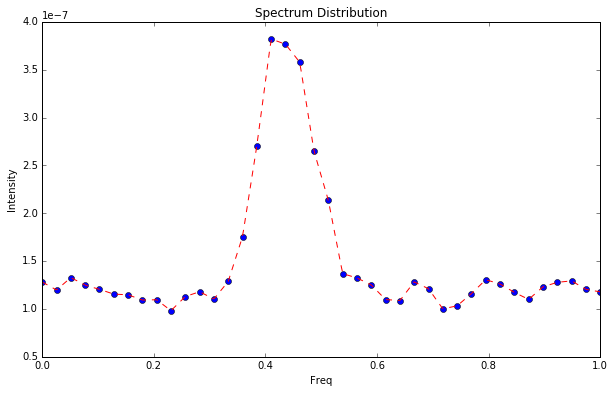

In [6]:
plt.figure(figsize=(10,6))
plt.plot(x, f_data, 'bo', x_, f(x_), 'r--')
plt.title('Spectrum Distribution')
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.show()

In [7]:
#setting parameters
a = 0.001
b = 0.1
N = 20

z = sym.Symbol('z')

#Penalizing function and its derivatives
psi1 = sym.exp(z)
d1psi1 = sym.diff(psi1, z)
d1psi1 = sym.lambdify(z, d1psi1, modules='numpy')

#Smoothing function and its derivatives
lamb = 0.5
#psi2 = 2*lamb*sym.log(1 + z**2/lamb)
psi2 = z**3
d1psi2 = sym.diff(psi2, z)
d2psi2 = sym.diff(d1psi2, z)
d1psi2 = sym.lambdify(z, d1psi2, modules='numpy')
d2psi2 = sym.lambdify(z, d2psi2, modules='numpy')

In [8]:
"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, sig):
    retval = ne.evaluate('exp(-x**2/(2*sig**2))')
    #retval = np.exp(-x**2/(2*sig**2))
    return retval

def phix(x, sig):
    retval = ne.evaluate('-(1./sig**2) * exp(-x**2/(2*sig**2)) * x')
    #retval = -(1./sig**2) * np.exp(-x**2/(2*sig**2)) * x
    return retval

def phixx(x, sig):
    retval = ne.evaluate('(1./sig**4) * exp(-x**2/(2*sig**2)) * (x**2 - sig**2)')
    #retval = (1./sig**4) * np.exp(-x**2/(2*sig**2)) * (x**2 - sig**2)
    return retval

In [9]:
""" Computing collocation points """
xc = np.linspace(0., 1., N+1)[1::]-(1./(2.*N))
print(xc)

""" Computing evaluation points """
xe = np.linspace(0., 1., 2*N, endpoint=True)
print(xe)

""" Computing the values of f at evaluation points """
f0 = f(xe)

""" 
Computing distance matrix.
Note: Evaluation and collocation points will be the same
"""
Dx = np.empty((2*N,N))
for k in range(2*N):
	Dx[k,:] = (xe[k] - xc)

[ 0.025  0.075  0.125  0.175  0.225  0.275  0.325  0.375  0.425  0.475
  0.525  0.575  0.625  0.675  0.725  0.775  0.825  0.875  0.925  0.975]
[ 0.          0.02564103  0.05128205  0.07692308  0.1025641   0.12820513
  0.15384615  0.17948718  0.20512821  0.23076923  0.25641026  0.28205128
  0.30769231  0.33333333  0.35897436  0.38461538  0.41025641  0.43589744
  0.46153846  0.48717949  0.51282051  0.53846154  0.56410256  0.58974359
  0.61538462  0.64102564  0.66666667  0.69230769  0.71794872  0.74358974
  0.76923077  0.79487179  0.82051282  0.84615385  0.87179487  0.8974359
  0.92307692  0.94871795  0.97435897  1.        ]


In [10]:
def F(X):
    #unpacking parameters
    N = len(X)/2
    c = X[0:N]
    sig = X[N:]
    
    #quiting borders
    _Dx = Dx[1:-1]
    _f0 = f0[1:-1]
    
    #phi function's evaluation
    phi_m   = phi(_Dx, sig)
    phix_m  = phix(_Dx, sig)
    phixx_m = phixx(_Dx, sig)
    
    #computing the Euler-Lagrange equation
    u   = np.dot(phi_m, c)
    ux  = np.dot(phix_m, c)
    uxx = np.dot(phixx_m, c)
    el = 2.*(u-_f0) + a*d1psi1(u-_f0) - b*uxx*d2psi2(np.abs(ux))
    
    #evaluating at boundary
    bc = [np.dot(phi(-xc,sig),c), np.dot(phi(1.-xc,sig),c)]
    return np.concatenate([el,bc])

In [16]:
"""
Defining initial parameter values
"""
c0 = np.min(f_data)*np.ones(N)
sig0 = (1./(N))*np.ones(N)
X0 = np.concatenate([c0,sig0])

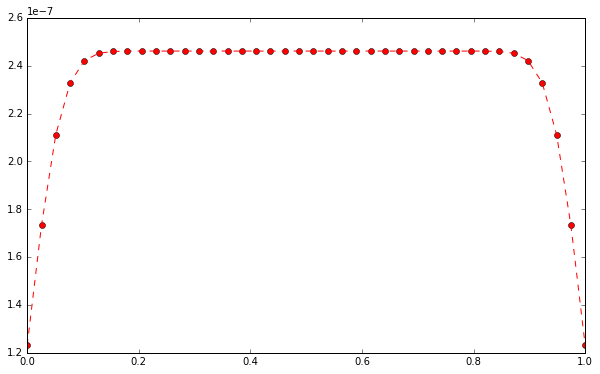

In [18]:
"""
Visualizing the 'initial' solution
"""
phi_m0 = phi(Dx, sig0)
u0 = np.dot(phi_m0, c0)
plt.figure(figsize=(10,6))
plt.plot(xe, u0, 'ro', xe, u0, 'r--')
plt.show()

In [19]:
"""
Solve it!
"""
X = sp.optimize.fsolve(F, X0)
c = X[0:N]
sig = X[N:]
print("c coeficients:"); print(c)
print('sigmas:'); print(sig)

c coeficients:
[ -4.86833712e-05  -3.84970087e-06  -1.41456598e-05   1.91807239e-06
   4.51722233e-06  -2.35481415e-05  -1.20936580e-05   3.50684527e-06
  -1.22470969e-05  -3.36212798e-05  -3.85319071e-05  -4.05041041e-05
  -6.28726845e-05  -5.90716739e-05  -3.85398160e-05   6.48945992e-07
  -5.73057342e-06  -5.69078044e-05  -7.51179894e-06  -6.08098264e-05]
sigmas:
[-30.30066755  -2.55713835  -4.00814374 -16.53631795 -23.77385024
  -0.64710778  -0.55649655  -5.21711465  -0.42628706   1.169905    -9.868517
  -0.73606083   1.33219828   1.01607494   4.07005934   0.98512238
  -8.78381927 -18.69750065 -13.31310932  -6.98799678]


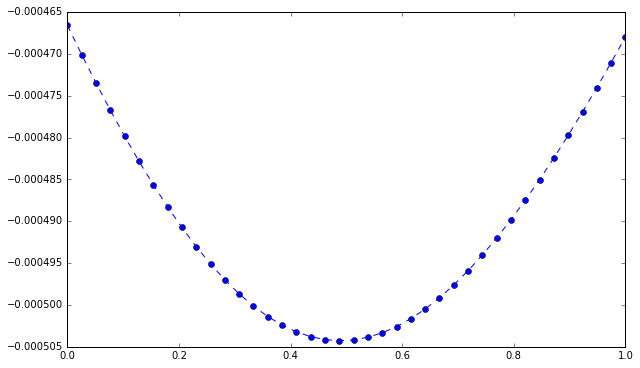

In [20]:
"""
Visualizing the result
"""
phi_m = phi(Dx, sig)
u = np.dot(phi_m, c)
plt.figure(figsize=(10,6))
plt.plot(xe, u, 'bo', xe, u, 'b--')
plt.show()